# Image Based Machine Learning

We extract all the images having a roman culture tag.
We than cluster these images in order to find different clusters of objects.
This is supposed to further enhance our analysis of this period, because we now have a knowledge of certain clusters of artifacts and can than use these results to see if some clusters were collected earlier or later. This can help us analyse if certain visual attributes were collected during different periods.

In [1]:
import numpy as np
from PIL import Image
import requests
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from io import BytesIO
import csv
import time
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2


# Load data

In [2]:
API_URL = "https://api.artic.edu/api/v1/artworks/search"
IIIF_TEMPLATE = "https://www.artic.edu/iiif/2/{image_id}/full/843,/0/default.jpg"
# Parameters
FIELDS = ["id", "title", "artist_display", "image_id", "date_end"]
LIMIT = 100  # max per page
TOTAL = 900

In [6]:
def fetch_artworks():
    results = []
    page = 1
    collected = 0

    while collected < TOTAL:
        params = {
            "page": page,
            "limit": LIMIT,
            "fields": ",".join(FIELDS),
            "q": "Roman"
        }

        response = requests.get(API_URL, params=params)
        data = response.json()

        for artwork in data.get("data", []):
            image_id = artwork.get("image_id")
            if not image_id:
                continue  # skip entries without image

            image_url = IIIF_TEMPLATE.format(image_id=image_id)
            results.append({
                "id": artwork["id"],
                "title": artwork.get("title", ""),
                "artist": artwork.get("artist_display", ""),
                "image_url": image_url,
                "date_end": artwork["date_end"]
            })

            collected += 1
            if collected >= TOTAL:
                break

        print(f"Collected {collected} artworks...")
        page += 1
        
        time.sleep(0.1)

    return results

In [ ]:
artworks = fetch_artworks()

In [ ]:
df = pd.DataFrame(artworks)

In [ ]:
df

,id,title,artist,image_url,date_end
0,61600,Statue of the Aphrodite of Knidos,Roman,https://www.artic.edu/iiif/2/aee665f2-bb63-2a2...,200.0
1,9978,Denarius (Coin) Depicting the God Apollo,"Roman, minted in Rome",https://www.artic.edu/iiif/2/98cf6c06-270f-fe8...,-90.0
2,845,Fragment of a Necklace,Roman; probably Egypt,https://www.artic.edu/iiif/2/051007c3-2ef5-64b...,300.0
3,5704,Aureus (Coin) Portraying Emperor Gordian III,"Roman, minted in Rome",https://www.artic.edu/iiif/2/dd12344b-a94f-c14...,239.0
4,532,Bottle,Roman; Syria or Palestine,https://www.artic.edu/iiif/2/69fa6133-2b25-30b...,100.0
...,...,...,...,...,...
895,141592,Denarius (Coin) Depicting the God Apollo,Roman,https://www.artic.edu/iiif/2/1ae2e74c-4ca0-4bf...,-67.0
896,141616,Denarius (Coin) Depicting the God Apollo,Roman,https://www.artic.edu/iiif/2/9243e9fd-548b-d3f...,-85.0
897,141620,Coin Depicting a Laureate,Roman,https://www.artic.edu/iiif/2/29fe4b60-d70c-0a2...,NaN
898,62035,Bottle,Roman; Levant or Syria,https://www.artic.edu/iiif/2/98cfa57e-26ba-8d4...,400.0


In [ ]:
df = df.dropna(subset=["image_url"]).sample(900, random_state=42).reset_index(drop=True)

# Download pictures

In [ ]:
def load_and_preprocess_image(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((224, 224))
        arr = img_to_array(img)
        arr = preprocess_input(arr)  # VGG16 normalization
        return arr
    except:
        return None

images = []
valid_indices = []

for idx, url in tqdm(enumerate(df["image_url"]), total=len(df)):
    img = load_and_preprocess_image(url)
    if img is not None:
        images.append(img)
        valid_indices.append(idx)

images = np.array(images)
df = df.iloc[valid_indices].reset_index(drop=True)

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [03:07<00:00,  4.81it/s]


# Load/ Save Data

In [ ]:
with open("../Data/images_roman.pickle", "wb") as f:
    pickle.dump(images, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("../Data/df_roman.pickle", "wb") as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open("../Data/images_roman.pickle", "rb") as f:
    images = pickle.load(f)

with open("../Data/df_roman.pickle", "rb") as f:
    df = pickle.load(f)

# Run models

In [4]:
model_vgg = VGG16(weights="imagenet", include_top=False, pooling="avg")  # use global average pooling
features_vgg = model_vgg.predict(images, batch_size=32, verbose=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step


In [5]:
model_mobile_net = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
features_mobile_net = model_mobile_net.predict(images, batch_size=32, verbose=1)

C:\Users\bened\AppData\Local\Temp\ipykernel_24668\1431890465.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_mobile_net = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step


# Compare results

In [6]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_vgg = tsne.fit_transform(features_vgg)

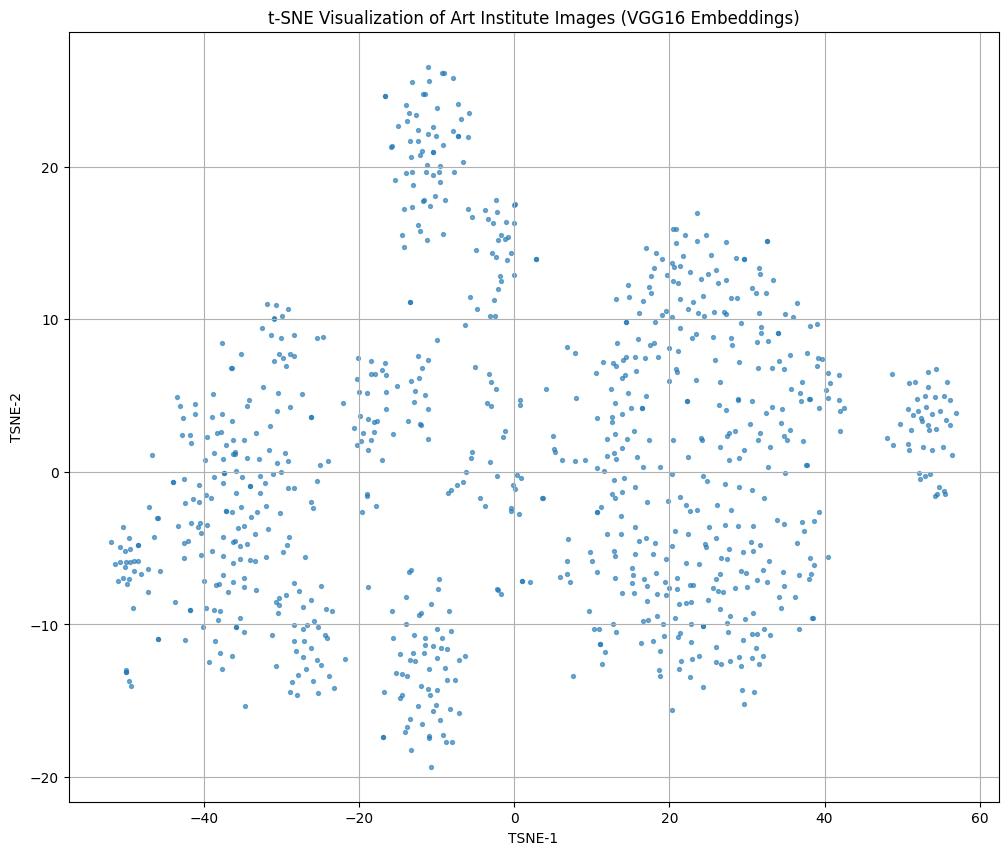

In [7]:
plt.figure(figsize=(12, 10))
plt.scatter(reduced_vgg[:, 0], reduced_vgg[:, 1], s=8, alpha=0.6)
plt.title("t-SNE Visualization of Art Institute Images (VGG16 Embeddings)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()

In [8]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_mobile_net = tsne.fit_transform(features_mobile_net)

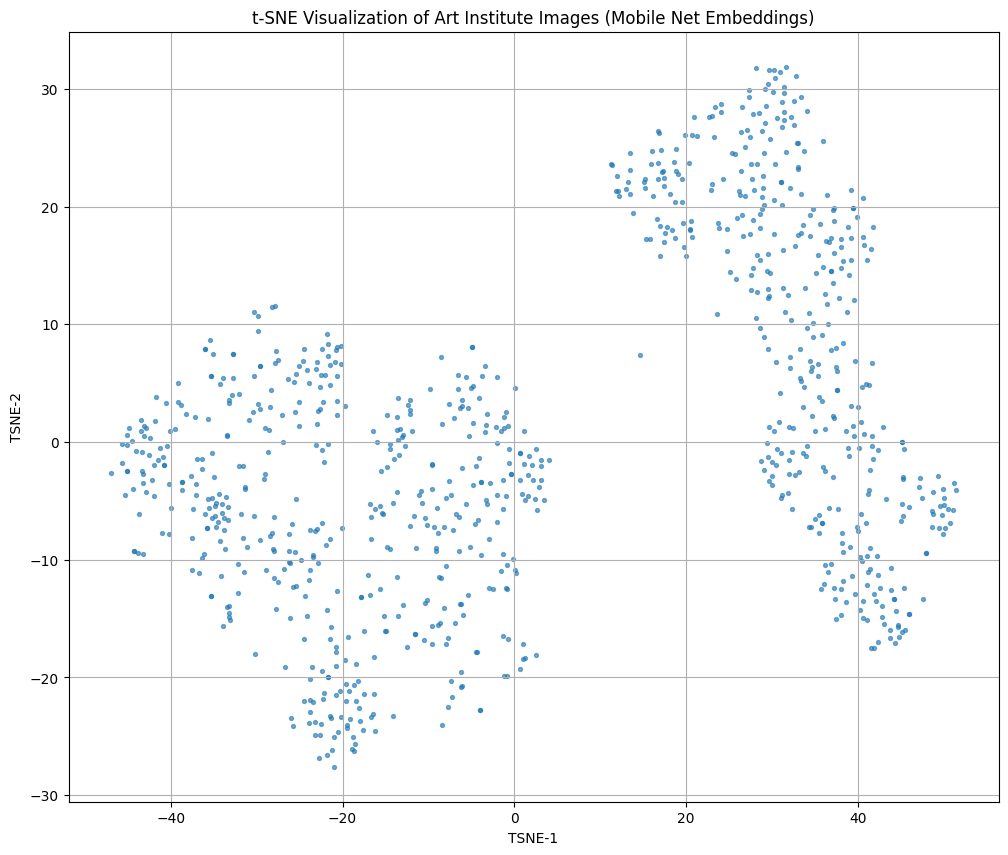

In [9]:
plt.figure(figsize=(12, 10))
plt.scatter(reduced_mobile_net[:, 0], reduced_mobile_net[:, 1], s=8, alpha=0.6)
plt.title("t-SNE Visualization of Art Institute Images (Mobile Net Embeddings)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()

In [10]:
# Load the model without the top classification layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobile = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Extract features
features_vgg = base_model_vgg.predict(images)  # Output shape: (n_images, 7, 7, 512)
features_flat_vgg = features_vgg.reshape(features_vgg.shape[0], -1)  # Flatten: shape (n_images, 25088)

# Extract features
features_mobile = base_model_mobile.predict(images)  # Output shape: (n_images, 7, 7, 512)
features_flat_mobile = features_mobile.reshape(features_mobile.shape[0], -1)  # Flatten: shape (n_images, 25088)

28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step


# Cluster

In [11]:
kmeans = KMeans(n_clusters=5, random_state=0)

clusters_vgg = kmeans.fit_predict(features_flat_vgg)

df["cluster_vgg"] = clusters_vgg

clusters_mobile = kmeans.fit_predict(features_flat_mobile)

df["cluster_mobile"] = clusters_mobile

In [16]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(features_flat_vgg)

df["x"] = coords[:, 0]
df["y"] = coords[:, 1]

import plotly.express as px

df["hover_text"] = df.apply(
    lambda row: f"Title: {row['title']}Cluster: {row['cluster_vgg']}", axis=1
)

# Build the interactive scatter plot
fig = px.scatter(
    df,
    x="x", y="y",
    color="cluster_vgg",
    hover_name="hover_text",
    hover_data={"x": False, "y": False, "cluster_vgg": False},
    title="Artwork Clusters (t-SNE + VGG16 Features)",
    width=950,
    height=750
)

# Clean hover template — show only custom hover text, no extra info
fig.update_traces(hovertemplate="%{hovertext}")

import plotly.io as pio
pio.renderers.default = 'browser'

# Show plot
fig.show()

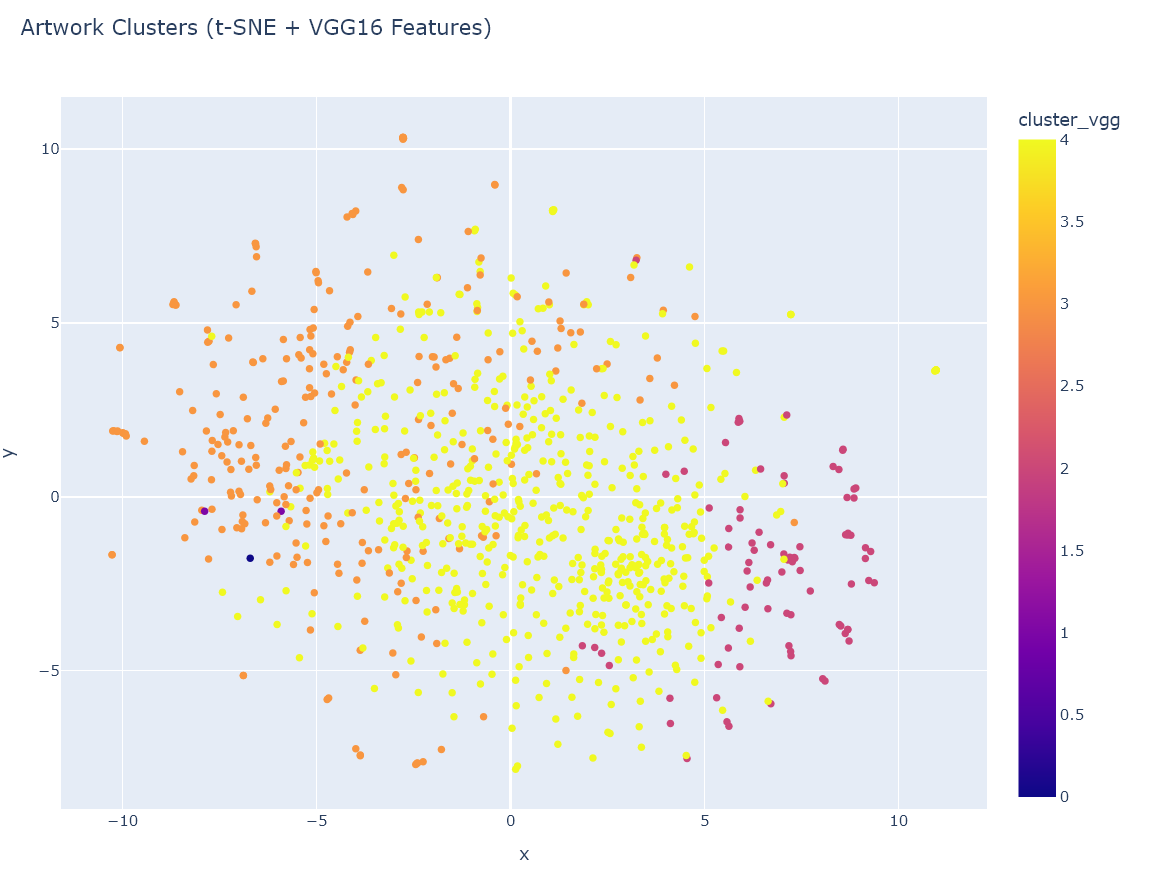

In [13]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(features_flat_mobile)

df["x"] = coords[:, 0]
df["y"] = coords[:, 1]

import plotly.express as px

df["hover_text"] = df.apply(
    lambda row: f"Title: {row['title']}Cluster: {row['cluster_mobile']}", axis=1
)

# Build the interactive scatter plot
fig = px.scatter(
    df,
    x="x", y="y",
    color="cluster_mobile",
    hover_name="hover_text",
    hover_data={"x": False, "y": False, "cluster_mobile": False},
    title="Artwork Clusters (t-SNE + Mobile Net Features)",
    width=950,
    height=750
)

# Clean hover template — show only custom hover text, no extra info
fig.update_traces(hovertemplate="%{hovertext}")

import plotly.io as pio
pio.renderers.default = 'browser'

# Show plot
fig.show()

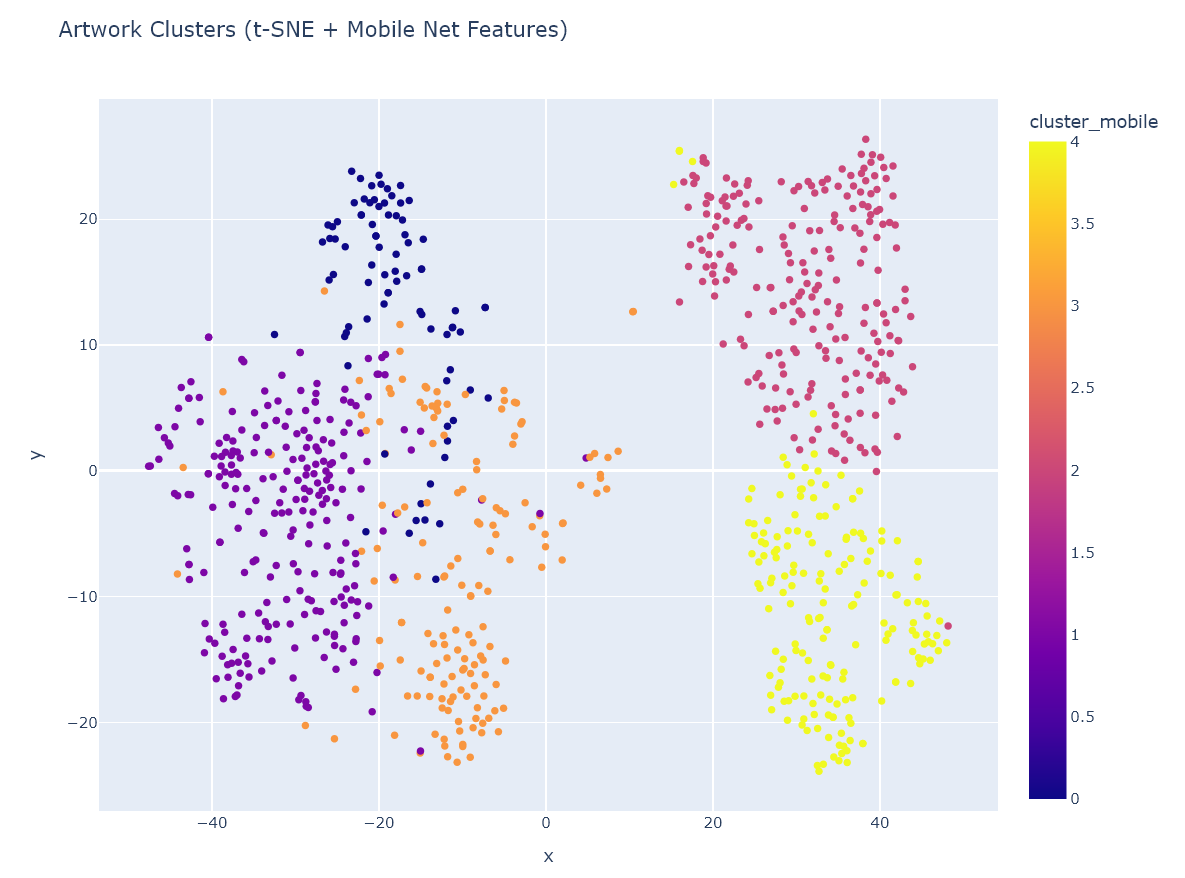
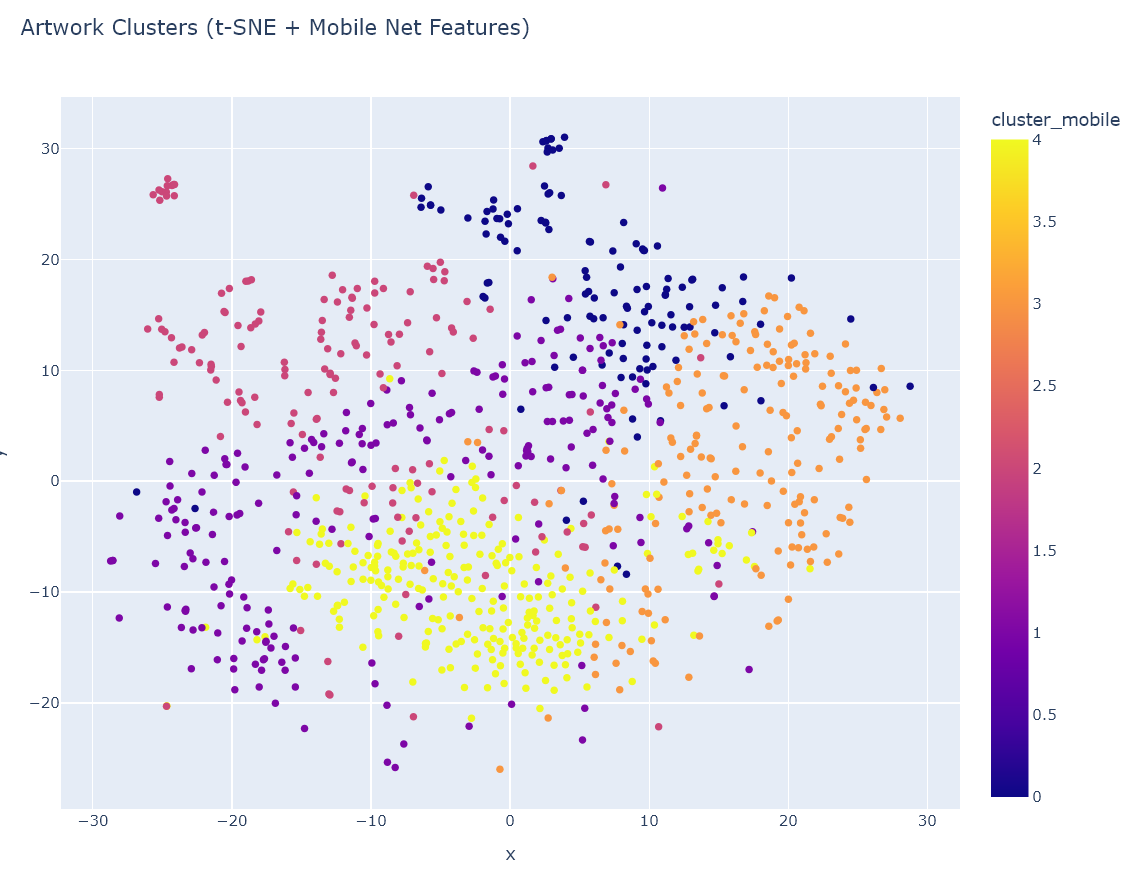

# Cluster content

## VGG

In [14]:
from IPython.display import display, Image, HTML

for cluster_id in sorted(df["cluster_vgg"].unique()):
    print(f"\n### Cluster {cluster_id} samples:\n")

    # Get the first 3 items from this cluster
    cluster_subset = df[df["cluster_vgg"] == cluster_id].head(3)

    for _, row in cluster_subset.iterrows():
        print(f"Title: {row['title']}")
        display(Image(url=row['image_url'], width=200))
        print("\n" + "*"*50)



### Cluster 0 samples:

Title: Jar



**************************************************
Title: Double-Handled Flask



**************************************************
Title: Bottle



**************************************************

### Cluster 1 samples:

Title: Denarius (Coin) Depicting the Goddess Roma



**************************************************
Title: Denarius (Coin) Portraying Emperor Antoninus Pius



**************************************************
Title: Denarius (Coin) Depicting the Goddess Ceres



**************************************************

### Cluster 2 samples:

Title: Aureus (Coin) Portraying Emperor Nero



**************************************************
Title: Tetradrachm (Coin) Portraying King Ptolemy II Philadelphos and Queen Arsinoe II



**************************************************
Title: Sestertius (Coin) Portraying Empress Faustina



**************************************************

### Cluster 3 samples:

Title: Fragment of a Bowl



**************************************************
Title: Calphurnius, from The Roman Heroes



**************************************************
Title: Funerary Mask



**************************************************

### Cluster 4 samples:

Title: Beaker or Cup



**************************************************
Title: Plate



**************************************************
Title: Bowl



**************************************************


# Mobile Net

In [15]:
from IPython.display import display, Image, HTML

for cluster_id in sorted(df["cluster_mobile"].unique()):
    print(f"\n### Cluster {cluster_id} samples:\n")

    # Get the first 3 items from this cluster
    cluster_subset = df[df["cluster_mobile"] == cluster_id].head(3)

    for _, row in cluster_subset.iterrows():
        print(f"Title: {row['title']}")
        display(Image(url=row['image_url'], width=200))
        print("\n" + "*"*50)



### Cluster 0 samples:

Title: Funerary Mask



**************************************************
Title: Amulet of the God Bes



**************************************************
Title: Statue of Meleager



**************************************************

### Cluster 1 samples:

Title: Calphurnius, from The Roman Heroes



**************************************************
Title: Bull of the Roman Campagna



**************************************************
Title: The Elliott Room (Charter Series)



**************************************************

### Cluster 2 samples:

Title: Aureus (Coin) Portraying Emperor Nero



**************************************************
Title: Tetradrachm (Coin) Portraying King Ptolemy II Philadelphos and Queen Arsinoe II



**************************************************
Title: Denarius (Coin) Depicting the Goddess Roma



**************************************************

### Cluster 3 samples:

Title: Fragment of a Bowl



**************************************************
Title: Intaglio Depicting a Horse



**************************************************
Title: Lamp



**************************************************

### Cluster 4 samples:

Title: Sestertius (Coin) Portraying Empress Faustina



**************************************************
Title: Coin Portraying Emperor Diadumenian



**************************************************
Title: Denarius (Coin) Depicting a Bearded Man



**************************************************
